# Introduction

This project is the capstone project of the [Udacity Datascience Nangodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025). It attempts to use ML techniques such as LSTMs to predict the prices of crypto currencies. The inputs to the algorithm will be trading data over a given data range and the prediction will be the adjusted close price.

The accompanying web app will allow the selection of a given cyrpto currency from a dropdown, a given input data range and a given algorithm. 


# Imports and helper functions

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import scipy.stats as stats
import plotly.offline as offline_py

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from datetime import datetime

In [9]:
# Check TF 2.0
import tensorflow as tf
print(tf.__version__)

2.4.1


In [10]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout, Conv1D

In [11]:
color_scheme = {
    'index': '#B6B2CF',
    'etf': '#2D3ECF',
    'tracking_error': '#6F91DE',
    'df_header': 'silver',
    'df_value': 'white',
    'df_line': 'silver',
    'heatmap_colorscale': [(0, '#6F91DE'), (0.5, 'grey'), (1, 'red')],
    'background_label': '#9dbdd5',
    'low_value': '#B6B2CF',
    'high_value': '#2D3ECF',
    'y_axis_2_text_color': 'grey',
    'shadow': 'rgba(0, 0, 0, 0.75)',
    'major_line': '#2D3ECF',
    'minor_line': '#B6B2CF',
    'main_line': 'black'}

def generate_config():
    return {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}

def _generate_traces(name_df_color_data):
    traces = []

    for name, df, color in name_df_color_data:
        traces.append(go.Scatter(
            name=name,
            x=df.index,
            y=df,
            mode='lines',
            line={'color': color}))

    return traces

def days_to_weeks(open_prices, high_prices, low_prices, close_prices):
    """Converts daily OHLC prices to weekly OHLC prices.
    
    Parameters
    ----------
    open_prices : DataFrame
        Daily open prices for each ticker and date
    high_prices : DataFrame
        Daily high prices for each ticker and date
    low_prices : DataFrame
        Daily low prices for each ticker and date
    close_prices : DataFrame
        Daily close prices for each ticker and date

    Returns
    -------
    open_prices_weekly : DataFrame
        Weekly open prices for each ticker and date
    high_prices_weekly : DataFrame
        Weekly high prices for each ticker and date
    low_prices_weekly : DataFrame
        Weekly low prices for each ticker and date
    close_prices_weekly : DataFrame
        Weekly close prices for each ticker and date
    """
    
    # TODO: Implement Function
    
    open_prices_weekly = open_prices.resample('W').first()
    high_prices_weekly = high_prices.resample('W').max()
    low_prices_weekly = low_prices.resample('W').min()
    close_prices_weekly = close_prices.resample('W').last()
    
    return open_prices_weekly, high_prices_weekly, low_prices_weekly, close_prices_weekly

# Bitcoin Price Data

To begin, let's take a look a historical bitcoin (btc) price data.

We use yfinance to source the data, which includes the open, high, low, close (OHLC) data in addition to the adjusted close price and the volume traded that day.

The open price is the price of the stock at the start of that trading data, the high is the highest price the stock attains over the course of the day, the low is likewise the lowest price over the day and the close is the price of the stock at the end of trading that day. 

The adjusted close is to take into account things like dividends being paid out.

The volume is the number of shares traded over the day.Generally large volumes of buy orders would increase a stock's price and large volumes of sell orders would decrease its price.

In [12]:
BTC_price_data = yf.download('BTC-USD','2012-04-01', time.strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [13]:
BTC_price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


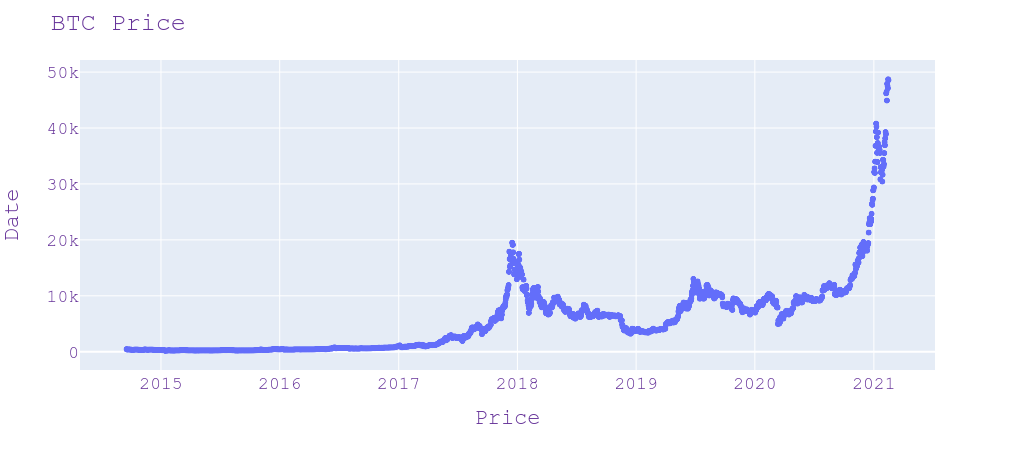

In [14]:
# Visualize
#pio.renderers.default = 'colab'

fig = px.scatter(x=BTC_price_data.index, y=BTC_price_data['Adj Close'])
fig.update_layout(
    title="BTC Price",
    xaxis_title="Price",
    yaxis_title="Date",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

We see that the price of Bitcoin is extremely volatile, with huge peaks in late 2017 and again in early 2021.

# Log Returns

Trying to run a ML algorithm on the raw price data is likely to not be too successful. The scale of the price from month to month may be drastically different and typically with ML algorithms and statistical techniques we want our input data to be normalized. 



Recall that the raw return (also known as the simple return, linear return or percentage return) is defined as:

$$
r_t = \frac{P_t-P_{t-1}}{P_{t-1}}
$$

where $P_t$ is the stock price at a given time $t$ and $P_{t-1}$ is the stock price at the precious time interval.


If our price on day 1 is 1000 and on day 2 it's 1100 we have a 10% return. Likewise if our price is 10,000 on day 1 and 11,000 on day 2, we still have a 10% return. 

Going even one step further, we typically want to define a related quantity called the *log return*, $R_t$, as

$$R_t = \log_e{\left(\frac{P_t}{P_{t-1}}\right)}= log_e(P_t) - log_e(P_{t-1})$$


so that

$$
e^{R_t} = r_t+1
$$

or

$$
r_t=e^{R_t}-1
$$

Log returns have a bunch of nice properties:

- The log return is the same as the continuously compounded return
- additive over time (e.g. to get the log return over 1 year you can simply add together the log returns over each month)
- Numerically stable

For more details see [why log returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

# Normality and long-term investments


If $r_{10}=\frac{p_1-p_0}{p_0}$ and $r_{21}=\frac{p_2-p_1}{p_1}$ then by the CLT their sum would also be normally-distrubted if they themselves were.

However, the two-period return is not the sum

$$
\begin{align}
r_{2,0}+1 &= \frac{p_2-p_0}{p_0}+1\\
&=\frac{p_2}{p_0}\\
&=\frac{p_1}{p_0}\times\frac{p_2}{p_1}\\
&=(1+r_{1,0})(1+r_{2,1})
\end{align}
$$


Generally returns go like

$$
1+r_{n,0}=(1+r_{1,0})(1+r_{2,1})\dots(1+r_{n,n-1})
$$

However in terms of log returns (take the log of the LHS and RHS) :

$$
R_{n,0} = R_{1,0}+R_{2,0}+\dots + R_{n,n-1}
$$

This means that by the CLT the log returns are normally distributed and the returns themselves are log-normally distributed.

In [15]:
def compute_returns(prices):
    """
    Compute returns from prices (adj close prices for example)
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    return (prices- prices.shift(1))/prices.shift(1)

In [16]:
def compute_log_returns(prices):
    """
    Compute log returns 
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """
    return np.log(prices) - np.log(prices.shift(1))

In [17]:
def log_returns_to_returns(log_returns):
    """
    Convert log returns back into returns
    
    Parameters
    ----------
    log_returns : Series
        Log returns
    
    Returns
    -------
    returns : The raw returns
    """
    return np.exp(log_returns) - 1

In [18]:
def standardize(df, colname):
    """
    Standard by subtracting the mean and diving by the standard deviation
    
    Parameters
    ----------
    df : DataFrame
    colnamne: column name to apply standardization to    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    
    Returns

    """
    mean = df[colname].mean()
    std = df[colname].std()
    return (df[colname]-mean)/(std)

In [19]:
def unstandardize(df, colname, mean, std):
    """
    Unstandardize by multiplyging by the std and adding the mean of the original distr
    
    Parameters
    ----------
    df : DataFrame
    colnamne: column name to apply standardization to    -------
    mean: mean of orig distribution
    std: std dev of orig distribution
    
    Returns
        unstandardized series
    """
    return (std*df[colname])+mean

In [20]:
def returns_to_prices(df, colname, price_zero):
    """
    Starting with price at time 0, `p_0`, then get the series of prices
    e.g p_n = (1_r_n)...(1+r1)p_0
    
    Parameters
    ----------
    df : DataFrame
    colnamne: returns column name to compute prices from
    price_zero: starting price
    
    Returns
        series of prices
    """
    return price_zero*df[colname].fillna(0).add(1).cumprod()

# The distribution of Bitcoin returns

In [21]:
BTC_price_data['Returns'] = compute_returns(BTC_price_data['Adj Close'])

In [22]:
BTC_price_data['Adj Close'].head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Adj Close, dtype: float64

In [23]:
returns_to_prices(BTC_price_data, 'Returns', BTC_price_data['Adj Close'].iloc[0])

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2021-02-11    47909.332031
2021-02-12    47504.851563
2021-02-13    47105.515625
2021-02-14    48717.289063
2021-02-15    48558.550781
Name: Returns, Length: 2340, dtype: float64

In [24]:
BTC_price_data['Standard Returns'] = standardize(BTC_price_data, 'Returns')

In [25]:
BTC_price_data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Standard Returns
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,-1.921477
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,-1.867888
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,0.848378
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,-0.705406


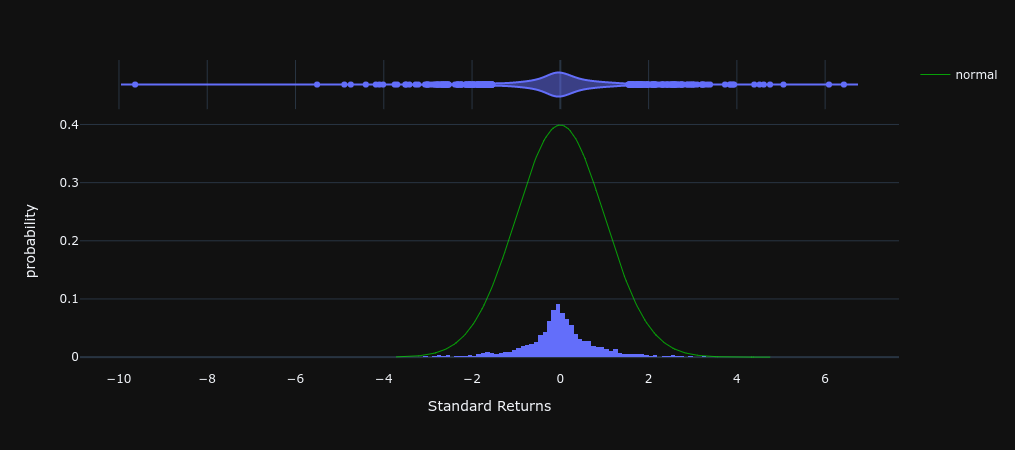

In [27]:
fig = px.histogram(BTC_price_data['Standard Returns'] , x="Standard Returns", marginal="violin",
                   hover_data=['Standard Returns'], histnorm='probability')

# Standard normal
ndist = stats.norm(loc=0, scale=1)
low_bound = ndist.ppf(.0001)
high_bound = ndist.ppf(.999999)
x_norm = np.linspace(low_bound, high_bound, 201)
y_norm = ndist.pdf(x_norm)

fig.add_traces(go.Scatter(x=x_norm, y=y_norm, mode = 'lines',
                          line = dict(color='rgba(0,255,0, 0.6)',
                                      width = 1
                                     ),
                          name = 'normal'
                         ))

fig.update_layout(template = 'plotly_dark')


fig.show()

# The distribution of Bitcoin log returns

In [20]:
BTC_price_data['Log Returns'] = compute_log_returns(BTC_price_data['Adj Close'])

In [21]:
BTC_price_data['Standard Log Returns'] = standardize(BTC_price_data, 'Log Returns')

In [22]:
orig_mean = BTC_price_data['Log Returns'].mean()
orig_std = BTC_price_data['Log Returns'].std()

In [23]:
BTC_price_data['Log Returns']

Date
2014-09-17         NaN
2014-09-18   -0.074643
2014-09-19   -0.072402
2014-09-20    0.035111
2014-09-21   -0.024968
                ...   
2021-02-08    0.171821
2021-02-09    0.006143
2021-02-10   -0.034203
2021-02-11    0.064468
2021-02-12   -0.013498
Name: Log Returns, Length: 2337, dtype: float64

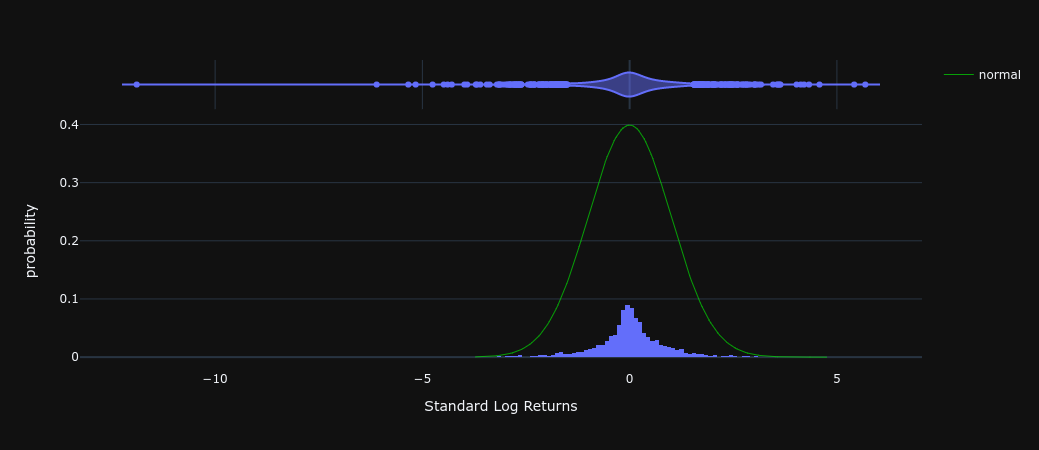

In [24]:
fig = px.histogram(BTC_price_data['Standard Log Returns'], x="Standard Log Returns",
                   marginal="violin", hover_data=['Standard Log Returns'], histnorm='probability')

# Standard normal
ndist = stats.norm(loc=0, scale=1)
low_bound = ndist.ppf(.0001)
high_bound = ndist.ppf(.999999)
x_norm = np.linspace(low_bound, high_bound, 201)
y_norm = ndist.pdf(x_norm)

fig.add_traces(go.Scatter(x=x_norm, y=y_norm, mode = 'lines',
                          line = dict(color='rgba(0,255,0, 0.6)',
                                      width = 1
                                     ),
                          name = 'normal'
                         ))

fig.update_layout(template = 'plotly_dark')


fig.show()

# Outliers

In [25]:
BTC_price_data.sort_values(by='Returns')['Returns'].head()

Date
2020-03-12   -0.371695
2015-01-14   -0.211449
2017-09-14   -0.187411
2015-08-18   -0.181788
2018-01-16   -0.168548
Name: Returns, dtype: float64

In [26]:
BTC_price_data.sort_values(by='Returns', ascending=False)['Returns'].head()

Date
2017-12-07    0.252472
2017-07-20    0.239361
2017-12-06    0.199283
2021-02-08    0.187465
2020-03-19    0.181878
Name: Returns, dtype: float64

We see the tail for some of the biggest drops were 12th of March 2020 (Covid-19), and the biggest return was in the bull-run of late 2017.

# Volatility and mean daily returns

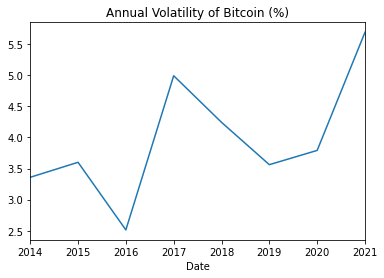

In [27]:
fig = (100*BTC_price_data['Returns']).resample('Y').std().plot(title='Annual Volatility of Bitcoin (%)')

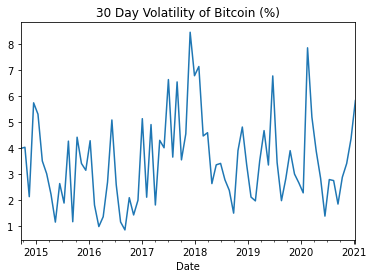

In [28]:
fig = (100*BTC_price_data['Returns']).resample('30D').std().plot(title='30 Day Volatility of Bitcoin (%)')

In [29]:
# Mean daily return
BTC_price_data['Returns'].mean()*100

0.27527241418569226

# Idea 1: Tensorflow LSTM for univariate forecasts

The initial idea is to try an LSTM. It will window the series of log returns (formed from the adjusted close prices) and use the historic log returns to try and predict a future value.

## Some config

Here are a bunch of LSTM helper functions

In [30]:
def split_data(data, training_size=0.8):
    """
    Split the data into training and test sets
    We want to preserve order and not shuffle at this stage as past points will be used to predict next in the sequence
    The test set will represent the unseen future
    However the windowed dataset will shuffle around each windows and along with target label (see that func)
    
    Params:
        data: the dataset
        training_sie: the split e.g. 0.8 means 80% of data is used in the training set
    """
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

In [136]:
def windowed_dataset(series, shuffle_buffer, window_len, batch_size):
    """
    If we have a series like [1,2,3,4,5,6]
    We want to split it into windows, e.g. we take previous value of the series
    as the X input features and want to predict the following value as output Y
    e.g. [1,2] - > 3, so what we want to do is split the data into windows
    of length window_len + 1 (the +1 acconts for the label)
    E.g.
      [1, 2, 3]
      [2, 3, 4]
      [3, 4, 5]
      [4, 5, 6]


    We shuffle the data to avoid bias

    Finally we split the example into input/target

    [[1, 2], [3]]
    .
    .

    so it's appropriate to feed into the model.fit    

    and we batch it into batches of batch_size
    
    Params:
        series: the series upon which we perform the windowing
        shuffle_buffer: size of the buffer when shuffling
            (see https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly#shuffle)
        window_len; how many previous elements to take into account when predicting the next
        batch_size: https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=nightly#batch
    """
    # Initially the data is (1188,) expand dims to TensorShape([1188, 1])
    series = tf.expand_dims(series, axis=-1)
    
    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    # will be an iterable of tf.Tensor([998.325], shape=(1,), dtype=float32),...
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0
    # The +1 accounts for the label too. Create a bunch of windows over our series
    # If we started with ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5])
    # then ds = ds.window(3, shift=1, drop_remainder=False) would lead
    # to [1,2,3], [2, 3, 4], [3, 4, 5], [4, 5], [5] whereas 
    # drop_remainder=True) => [1,2,3], [2, 3, 4], [3, 4, 5]
    # Remember the first window_len are our training data and the 1 is 
    # the target/label
    # Could also do this with pandas shift
    ds = ds.window(window_len + 1, shift=1, drop_remainder=True)
    #for w in ds:
    #    print(list(w.as_numpy_iterator()))
    
    # Maps map_func across this dataset and flattens the result
    ds = ds.flat_map(lambda w: w.batch(window_len + 1))

    # randomize order 
    ds = ds.shuffle(shuffle_buffer)
    
    # Collect the inputs and the label
    ds = ds.map(lambda w: (w[:-1], w[-1]))

    return ds.batch(batch_size).prefetch(1)

In [137]:
def preprocessing(df, scaler=None, colname='Adj Close', window_len=5, start_date=None, end_date=None, shuffle_buffer=1000,
                  batch_size=128, **kwargs):
    """
    Data preprocessing.
     - First keep only data between the start and end date
     - Compute the log returns from the adjusted close prices
     - Use a standard scalar to normalize that data
     - Split into training and test sets
     
     Params:
         df - The OHLC dataframe
         colname - The column we want to make predictions for (close prices)
         window_len - how many elements to use from the series when predicting the next
         start_date/end_date - The data range to model over (for example we may want to exclude
            the early days of bitcoin with the long tail)
        shuffle_buffer - buffer size for shuffling
        batch_size - size of batches
     
     Returns:
         training_price_zero - the initial price in the training set (useful when reconstructing prices from rets)
         test_price_zero - the initial price in the test set (useful when reconstructing prices from rets)
         scaler - the standard scalar (use it to do inverse transform later)
         
         model_training_data - the windowed dataset and target labels to train the NN on
         
         training_data - the series of log returns in the training set
         test_data - the series of log returns in the test set
         
         training_dates - the date series for training set
         test_dates - the date series for test set
    """

    # Date range of interest
    temp_df = df
    if start_date is not None:
        temp_df = temp_df[temp_df.index >= start_date]
    if end_date is not None:
        temp_df = temp_df[temp_df.index <= end_date]
        
    
    # First get the log returns
    log_rets_df = compute_log_returns(temp_df[colname]).iloc[1:]

        
    # Split into training/test datasets
    training_df, test_df = split_data(log_rets_df)
    
    if scaler == 'minmax':
        print('use min max scaling')
        training_scaler = MinMaxScaler()  
        test_scaler = MinMaxScaler()
    elif scaler == 'robust':
        training_scaler = RobustScaler()  
        test_scaler = RobustScaler()
    elif scaler == 'standard':
        training_scaler = StandardScaler()  
        test_scaler = StandardScaler()
    else:
        training_scaler = test_scaler = None

    if training_scaler and test_scaler:
        training_data = training_scaler.fit_transform(training_df.values.reshape(-1, 1)).flatten()
        test_data = test_scaler.fit_transform(test_df.values.reshape(-1, 1)).flatten()
    else:
        print('no scaling')
        training_data = training_df.values
        test_data = test_df.values
        
    # Remember scalar.inverse_transform should transform back the data too so we return the scaler too
      
    # Windowed/batched training data to feed the model
    windowed_training_data = windowed_dataset(training_data, shuffle_buffer, window_len, batch_size)

    # # This will help with the displaying of results etc
    # Training and test dates for plotting comparisons
    training_dates = training_df.iloc[window_len: ].index
    test_dates = test_df.iloc[window_len:].index
    
    # Starting prices (from day before first return)
    training_price_zero = temp_df.loc[training_df.index[window_len-1]]['Adj Close']
    test_price_zero = temp_df.loc[test_df.index[window_len-1]]['Adj Close']

    return training_price_zero, test_price_zero, training_scaler, test_scaler, windowed_training_data, training_data, test_data, training_dates, test_dates    

In [138]:
def build_model(output_size, neurons, activ_func, dropout, loss, optimizer):
  """
  The keras model. Will try a Conv layer initially followed by a bunch of LSTM layers with dropout.
  
  Params:
     output_size: e.g. predict 1 point in the future
     neurons: how many nuerons for each LSTM later
     activ_func: activation func, e.g. tanh
     loss: loss function to use, e.g. mse
     optimizer: e.g. adam
     
  Returns:
     The model
  """
  model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=25, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  # tf.keras.layers.LSTM(neurons, input_shape=[None, None, 1], return_sequences=True, activation=activ_func),
  tf.keras.layers.LSTM(neurons, return_sequences=True, activation=activ_func),
  tf.keras.layers.Dropout(dropout),
#   tf.keras.layers.LSTM(neurons, return_sequences=True, activation=activ_func),
#   tf.keras.layers.Dropout(dropout),
#   tf.keras.layers.LSTM(neurons, return_sequences=True, activation=activ_func),
#   tf.keras.layers.Dropout(dropout),
#   tf.keras.layers.LSTM(neurons, return_sequences=False, activation=activ_func),
#   tf.keras.layers.Dropout(dropout),
  tf.keras.layers.Dense(units=output_size, activation=activ_func),
  ])
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [85]:
def model_forecast(model, series, window_len):
    """
    Take the model we just trained and make predictions.
    
    We window the dataset then try to predict the next values after the window.
    Note we do not shuffle this time as we are predicting not training, and want to compare also with
    actual prices.
    
    Parameters:
        model: the ML model trained
        series: the series on which to make predictions
        window_len: size of our window for making preds, e.g. previous 5 elem to predict next perhaps
    """
    # Initially the data is (N,) expand dims to TensorShape([N, 1])
    series = tf.expand_dims(series, axis=-1)

    # Now we just use window_len not +1, because we just want inputs not label, and we predict label
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_len, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_len))

    ds = ds.batch(32).prefetch(1)

    return model.predict(ds)

In [112]:
def display_results(model, scaler, dataset, price_zero, dates, window_len, output_size):
    """
    With our predictions we de-normalize the standardized log returns predicted, then convert them into raw
    returns, and finally prices.
    
    We plot those prices against the actual prices in the same date range
    
    We compute the MAE and print it.
    
    Params:
        model: the training model
        scaler: the scalar we can use to invert the normalization
        dataset: Maybe this is train or test set
        price_zero: the initial price in the date range that we will have a prediction for (used to convert returns
            back to prices)
        dates: the dates over this training set for which we expect predictions
        window_len: how many previous points used when predicting the next
    Returns:
        None
    """
    
    
    preds = model_forecast(model, dataset, window_len)
    
   
    # E.g if window_len is 5, we have predictions for [5:]  since [0, 1, 2, 3, 4] -> [5] etc. If the output_size=1
    # then we neglect the final pred since it uses the final 5 elements of training set to pred a subsequent element, which
    # we have no training data to compare with
    res_df = pd.DataFrame({'y': dataset.flatten()[window_len:], 'yhat': preds.flatten()[:-output_size]})
    
    # Want to inverse the normalization transform
    if scaler:
        res_df['y_unstandardized'] = scaler.inverse_transform(res_df['y'].values.reshape(-1, 1))
        res_df['yhat_unstandardized'] = scaler.inverse_transform(res_df['yhat'].values.reshape(-1, 1))
    else:
        res_df['y_unstandardized'] = res_df['y'].values.reshape(-1, 1)
        res_df['yhat_unstandardized'] = res_df['yhat'].values.reshape(-1, 1)
        
    # ...and also convert back to returns
    res_df['y_returns'] = res_df['y_unstandardized'].apply(log_returns_to_returns)
    res_df['yhat_returns'] = res_df['yhat_unstandardized'].apply(log_returns_to_returns)
                   
    # Before prices
    res_df['y_prices'] = returns_to_prices(res_df, 'y_returns', price_zero)
    res_df['yhat_prices'] = returns_to_prices(res_df, 'yhat_returns', price_zero)

    # Plot
    fig = go.Figure()
    fig.add_scatter(x=dates, y=res_df['y_prices'], mode='lines', name="Actual") 

    fig.add_scatter(x=dates, y=res_df['yhat_prices'], mode='lines', name="Predicted") 

    fig.update_layout(template = 'plotly_dark',
                      xaxis_title="Time",
                      yaxis_title="Price",)


    fig.show()
                                                  
    # Print the MAE    
    mae = mean_absolute_error(res_df['y'], res_df['yhat'])
    print(f'The MAE is {mae}')

In [113]:
def display_history(hist):
    """
    Simply plot the training history such as the MAE and Loss over time
    
    Params:
       hist: the history obj returned by Keras
       
    Returns:
        None
    """
    fig = px.line(hist.history['loss'], title='Loss over time')

    fig.update_layout(template = 'plotly_dark',
                      xaxis_title="Time",
                      yaxis_title="Loss",)


    fig.show()

    fig = px.line(hist.history['mae'], title='MAE over time')

    fig.update_layout(template = 'plotly_dark',
                      xaxis_title="Time",
                      yaxis_title="MAE",)


    fig.show()

## Attempt 1

In [139]:
## Config dict that defines this attempt
config1 = {
    "neurons": 20,                 # number of hidden units in the LSTM layer
    "activation_function": 'tanh',   # activation function for LSTM and Dense layer
    "loss": 'mse',                   # loss function for calculating the gradient, in this case Mean Squared Error. Could be mae
    "optimizer": 'adam',              # optimizer for appljying gradient decent
    "dropout": 0.25,                 # dropout ratio used after each LSTM layer to avoid overfitting
    "batch_size": 128,              
    "epochs": 50,                  
    "window_len": 5,                 # is an int to be used as the look back window for creating a single input sample.
    "training_size": 0.8,            # porportion of data to be used for training
    "shuffle_buffer": 1000,          # When shuffling the windowed Dataset how many at once to load into memory
    "output_size": 1,
    "start_date": '2018-01-01',
    "end_date": None,
}

In [140]:
# Clean up the memory
tf.keras.backend.clear_session()
btc_model1 = build_model(config1['output_size'], config1['neurons'], config1['activation_function'],
                         config1['dropout'], config1['loss'], config1['optimizer'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 25)          150       
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          3680      
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           21        
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________________________________


In [141]:
training_price_zero1, test_price_zero1, training_scaler1, test_scaler1, model_training_data1, training_data1, test_data1,\
training_dates1, test_dates1 = preprocessing(BTC_price_data, **config1)

no scaling


In [142]:
btc_history1 = btc_model1.fit(model_training_data1, epochs=config1['epochs'], batch_size=config1['batch_size'], verbose=1)

Epoch 1/50
8/8 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0267
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mae: 0.0281
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - mae: 0.0263
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0018 - mae: 0.0269
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0270
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0018 - mae: 0.0275
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - mae: 0.0270
Epoch 8/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - mae: 0.0294
Epoch 9/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0019 - mae: 0.0274
Epoch 10/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0263
Epoch 11/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - mae: 0.0

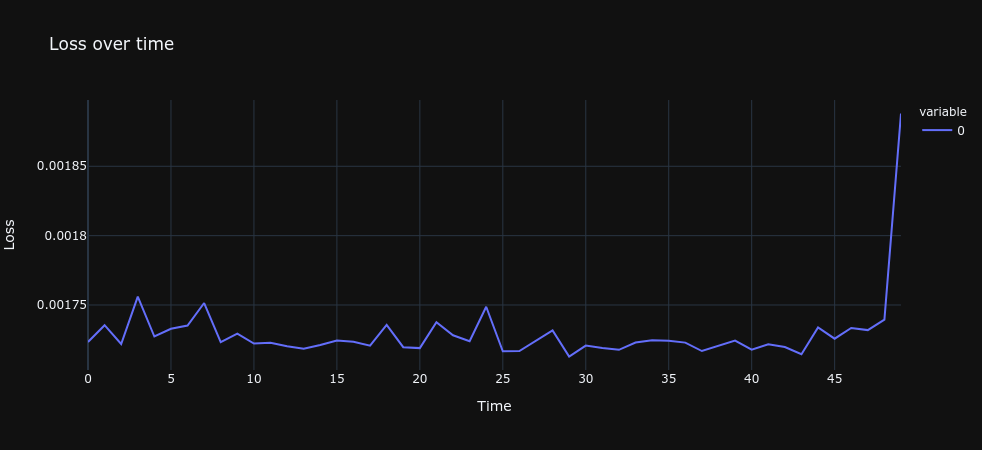

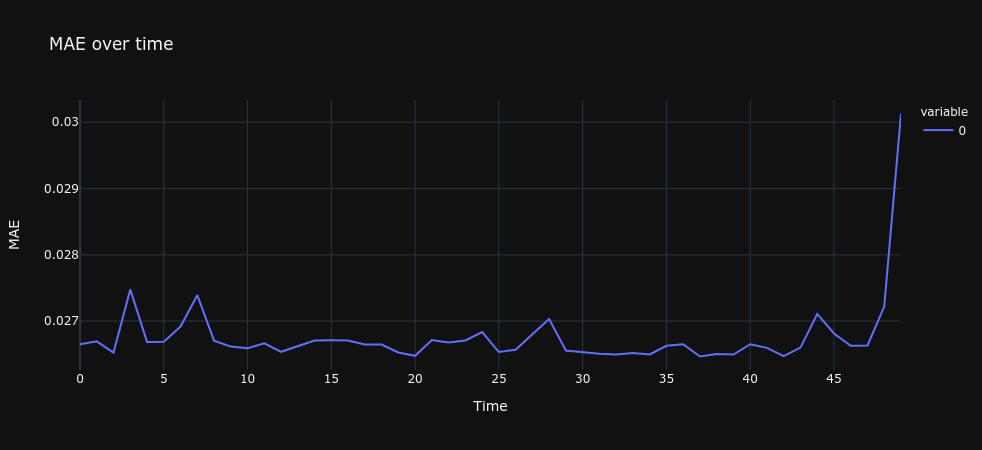

In [144]:
display_history(btc_history1)

In [145]:
display_results(btc_model1, training_scaler1, training_data1, training_price_zero1, training_dates1, config1['window_len'],config1['output_size'])

ValueError: arrays must all be same length

This did not work very well. The loss remained very high even over 100 epochs, although it was decreasing.
Is it just a matter of time? Could we do better with more epochs or a smaller training set?

## Attempt 2

Lowered the window len to 3. Moved start date to 2018-06-01

In [56]:
## Config dict that defines this attempt
config2 = {
    "neurons": 1024,                 # number of hidden units in the LSTM layer
    "activation_function": 'tanh',   # activation function for LSTM and Dense layer
    "loss": 'mse',                   # loss function for calculating the gradient, in this case Mean Squared Error. Could be mae
    "optimizer": 'adam',              # optimizer for appljying gradient decent
    "dropout": 0.25,                 # dropout ratio used after each LSTM layer to avoid overfitting
    "batch_size": 128,              
    "epochs": 250,                  
    "window_len": 3,                 # is an int to be used as the look back window for creating a single input sample.
    "training_size": 0.8,            # porportion of data to be used for training
    "shuffle_buffer": 1000,          # When shuffling the windowed Dataset how many at once to load into memory
    "output_size": 1,
    "start_date": '2018-06-01',
    "end_date": None,
}

In [57]:
# Clean up the memory
tf.keras.backend.clear_session()
btc_model2 = build_model(config2['output_size'], config2['neurons'], config2['activation_function'],
                         config2['dropout'], config2['loss'], config2['optimizer'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 25)          150       
_________________________________________________________________
lstm (LSTM)                  (None, None, 1024)        4300800   
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 1024)        0

In [58]:
training_price_zero2, test_price_zero2, training_scaler2, test_scaler2, model_training_data2, training_data2, test_data2,\
training_dates2, test_dates2 = preprocessing(BTC_price_data, **config2)

In [59]:
btc_history2 = btc_model2.fit(model_training_data2, epochs=config2['epochs'], batch_size=config2['batch_size'], verbose=1)

Epoch 1/250
7/7 [==============================] - 17s 2s/step - loss: 0.9206 - mae: 0.6047
Epoch 2/250
7/7 [==============================] - 11s 2s/step - loss: 0.9996 - mae: 0.6112
Epoch 3/250
7/7 [==============================] - 14s 2s/step - loss: 1.2354 - mae: 0.6418
Epoch 4/250
7/7 [==============================] - 12s 2s/step - loss: 0.9916 - mae: 0.6237
Epoch 5/250
7/7 [==============================] - 12s 2s/step - loss: 0.9607 - mae: 0.6203
Epoch 6/250
7/7 [==============================] - 11s 2s/step - loss: 0.9171 - mae: 0.6047
Epoch 7/250
7/7 [==============================] - 12s 2s/step - loss: 1.2106 - mae: 0.6254
Epoch 8/250
7/7 [==============================] - 15s 2s/step - loss: 1.0594 - mae: 0.6147
Epoch 9/250
7/7 [==============================] - 12s 2s/step - loss: 0.9154 - mae: 0.5980
Epoch 10/250
7/7 [==============================] - 10s 1s/step - loss: 1.1971 - mae: 0.6097
Epoch 11/250
7/7 [==============================] - 12s 2s/step - loss: 1.0439 